In [1]:
# Importing libraries
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Figure format
%config InlineBackend.figure_format = 'svg'

In [3]:
# Reading input files
nyc,preds = pd.read_csv('nyc_16.csv'), pd.read_csv('nyc_16_preds.csv')

In [4]:
first_col = nyc.iloc[:, 0]
remaining_cols = nyc.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
nyc = pd.concat([first_col, remaining_scaled], axis=1)

# Print the final DataFrame with the unscaled first column and scaled remaining columns
print(nyc)


      income  surface_volume_disorderliness_mean  \
0       8493                            0.006267   
1       8661                            0.000489   
2       8937                            0.022082   
3       9318                            0.000794   
4       9463                            0.016447   
...      ...                                 ...   
5785  250001                            0.013916   
5786  250001                            0.034909   
5787  250001                            0.039105   
5788  250001                            0.178122   
5789  250001                            0.009184   

      surface_roughness_disorderliness_mean  ndbi_built_contrast_mean  \
0                                  0.158896                  0.408502   
1                                  0.033812                  0.149230   
2                                  0.199797                  0.310865   
3                                  0.173963                  0.257893   
4         

In [5]:
first_col = preds.iloc[:, 0]
remaining_cols = preds.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
preds = pd.concat([first_col, remaining_scaled], axis=1)

# Print the final DataFrame with the unscaled first column and scaled remaining columns
print(preds)


        id  surface_volume_disorderliness_mean  \
0      390                            0.006267   
1     6310                            0.000489   
2     2936                            0.022082   
3      305                            0.000794   
4      131                            0.016447   
...    ...                                 ...   
5785  3899                            0.013916   
5786  3918                            0.034909   
5787  3919                            0.039105   
5788  4292                            0.178122   
5789  6332                            0.009184   

      surface_roughness_disorderliness_mean  ndbi_built_contrast_mean  \
0                                  0.158896                  0.408502   
1                                  0.033812                  0.149230   
2                                  0.199797                  0.310865   
3                                  0.173963                  0.257893   
4                                 

In [6]:
income = nyc['income']
id = preds['id']

In [7]:
y = nyc.income
X = preds.drop('id', axis=1)

In [8]:
X

,surface_volume_disorderliness_mean,surface_roughness_disorderliness_mean,ndbi_built_contrast_mean,tcap_wetness_mean,tcap_greenness_std,surface_structure_mean,nir_band_mean,swir2_band_std,colour_brightness_coherence_mean,ndwi_wetness_contrast_mean,ndwi_wetness_coherence_std,tcap_greenness_contrast_mean,tcap_wetness_coherence_mean,tcap_wetness_disorderliness_mean,x_coord,y_coord
0,0.006267,0.158896,0.408502,0.539548,0.437268,0.019910,0.478176,0.179310,0.555111,0.421591,0.140127,0.457379,0.233782,0.060141,0.592300,0.810670
1,0.000489,0.033812,0.149230,0.638601,0.415555,0.019948,0.576194,0.126290,0.466009,0.369334,0.258484,0.694239,0.125701,0.028486,0.161023,0.319708
2,0.022082,0.199797,0.310865,0.423982,0.554273,0.021465,0.543973,0.451725,0.666122,0.262683,0.146684,0.350375,0.291032,0.111900,0.629752,0.417431
3,0.000794,0.173963,0.257893,0.405166,0.310241,0.038767,0.463999,0.299712,0.411057,0.255753,0.154420,0.214495,0.365132,0.142114,0.648582,0.777505
4,0.016447,0.160993,0.436669,0.331400,0.497641,0.032117,0.469825,0.379323,0.477074,0.255965,0.173220,0.228364,0.287308,0.134921,0.606576,0.767894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5785,0.013916,0.116882,0.418343,0.844895,0.715219,0.017384,0.602109,0.204515,0.708393,0.323178,0.540064,0.270879,0.631447,0.698539,0.491105,0.696762
5786,0.034909,0.236760,0.404727,0.637000,0.263788,0.016079,0.312436,0.153726,0.549082,0.355889,0.723894,0.292057,0.339967,0.300666,0.496122,0.699625
5787,0.039105,0.279787,0.469610,0.655760,0.210605,0.015306,0.253289,0.153109,0.462156,0.359348,0.244453,0.307393,0.381655,0.200594,0.501540,0.701441
5788,0.178122,0.576251,0.782504,0.586392,0.389576,0.049969,0.366016,0.281109,0.771263,0.350988,0.320681,0.365179,0.428717,0.378213,0.429977,0.521742


In [9]:
dataset_dir = './inc_nyc'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.

nyc.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
preds.to_csv(
    os.path.join(dataset_dir, 'preds.csv'),
    index=False, sep=',', header=True
)

In [10]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(5790, 16)


Column names
dataset 1:
['surface_volume_disorderliness_mean', 'surface_roughness_disorderliness_mean', 'ndbi_built_contrast_mean', 'tcap_wetness_mean', 'tcap_greenness_std', 'surface_structure_mean', 'nir_band_mean', 'swir2_band_std', 'colour_brightness_coherence_mean', 'ndwi_wetness_contrast_mean', 'ndwi_wetness_coherence_std', 'tcap_greenness_contrast_mean', 'tcap_wetness_coherence_mean', 'tcap_wetness_disorderliness_mean', 'x_coord', 'y_coord']


TBB Warning: The number of workers is currently limited to 5. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [11]:
# Cross-validation split
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [12]:
# CatBoost model fitting
tuned_model = CatBoostRegressor(
    random_seed=63,
    iterations=1250,
    task_type="CPU",
    learning_rate=0.02,
    l2_leaf_reg = 55,
    depth = 4,
    loss_function='MAE'
)
tuned_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds=50,
    plot=True
)
results = tuned_model.get_evals_result()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Pearson correlation coefficient: 0.778689477768505
Spearman correlation coefficient: 0.7579639064741053


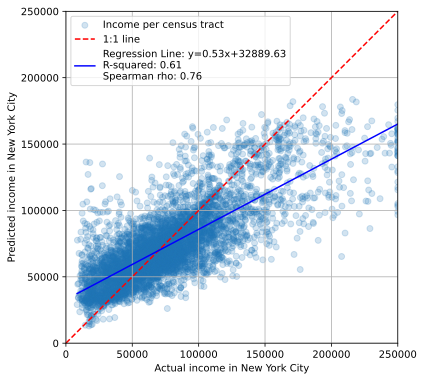

In [13]:
# Make predictions using the CatBoost model
predicted_values = tuned_model.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y.values.flatten(),  # Assuming y is a single-column DataFrame
    'Predicted': predicted_values
})

# Calculate Pearson's correlation coefficient
pearson_corr, _ = pearsonr(results_df['Actual'], results_df['Predicted'])
print(f'Pearson correlation coefficient: {pearson_corr}')

# Calculate Spearman's correlation coefficient
spearman_corr, _ = spearmanr(results_df['Actual'], results_df['Predicted'])
print(f'Spearman correlation coefficient: {spearman_corr}')

# Perform linear regression
reg_model = LinearRegression()
reg_model.fit(results_df[['Actual']], results_df['Predicted'])
predicted_reg = reg_model.predict(results_df[['Actual']])

# Calculate R-squared value
r_squared = r2_score(results_df['Predicted'], predicted_reg)

# Get regression parameters
slope = reg_model.coef_[0]
intercept = reg_model.intercept_

# Plotting scatter plot with regression line
plt.figure(figsize=(6, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.2, label='Income per census tract')
plt.plot([0, 250000], [0, 250000], color='red', linestyle='--', label='1:1 line')
regression_label = (f'Regression Line: y={slope:.2f}x+{intercept:.2f}\n'
                    f'R-squared: {r_squared:.2f}\n'
                    f'Spearman rho: {spearman_corr:.2f}')
plt.plot(results_df['Actual'], predicted_reg, color='blue', linestyle='-', label=regression_label)

plt.xlabel('Actual income in New York City')
plt.ylabel('Predicted income in New York City')
plt.legend()
plt.grid(True)
plt.xlim(0, 250000)
plt.ylim(0, 250000)
plt.gca().set_aspect('equal', adjustable='box')

# Save the plot as an SVG file
plt.savefig('scatter_plot_with_regression_and_shap_nyc.svg', format='svg')

plt.show()

In [14]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(tuned_model)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X)

# Extract SHAP values for the specific predictor 'tcap_wetness_mean'
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_surface_roughness_disorderliness_mean = shap_df['surface_roughness_disorderliness_mean']
shap_tcap_wetness_mean = shap_df['tcap_wetness_mean']
shap_colour_brightness_coherence_mean = shap_df['colour_brightness_coherence_mean']
shap_tcap_wetness_disorderliness_mean = shap_df['tcap_wetness_disorderliness_mean']
shap_surface_roughness_disorderliness_mean = shap_df['surface_roughness_disorderliness_mean']
shap_ndwi_wetness_contrast_mean = shap_df['ndwi_wetness_contrast_mean']
shap_ndwi_wetness_coherence_std = shap_df['ndwi_wetness_coherence_std']

# Create a DataFrame with actual values, predicted values, and SHAP values for 'tcap_wetness_mean'
results_with_shap_df = pd.DataFrame({
    'Actual': y.values.flatten(),  # Assuming y is a single-column DataFrame
    'Predicted': tuned_model.predict(X),
    'SHAP_surface_roughness_disorderliness_mean': shap_surface_roughness_disorderliness_mean,
    'SHAP_tcap_wetness_mean': shap_tcap_wetness_mean,
    'SHAP_colour_brightness_coherence_mean': shap_colour_brightness_coherence_mean,
    'SHAP_tcap_wetness_disorderliness_mean': shap_tcap_wetness_disorderliness_mean,
    'SHAP_surface_roughness_disorderliness_mean': shap_surface_roughness_disorderliness_mean,
    'SHAP_ndwi_wetness_contrast_mean': shap_ndwi_wetness_contrast_mean,
    'SHAP_ndwi_wetness_coherence_std': shap_ndwi_wetness_coherence_std
})

# Print the DataFrame
print(results_with_shap_df.head())


   Actual     Predicted  SHAP_surface_roughness_disorderliness_mean  \
0    8493  29067.795391                                -4025.917328   
1    8661  77582.912253                                  976.178960   
2    8937  44422.656657                                -3081.149514   
3    9318  34083.514541                                -3232.303864   
4    9463  34382.823384                                -3875.599138   

   SHAP_tcap_wetness_mean  SHAP_colour_brightness_coherence_mean  \
0             2618.741847                           -1648.294536   
1             4313.258489                              45.018282   
2            -1850.541563                           -2049.176671   
3            -3343.106979                            1221.536962   
4            -2943.637804                           -1206.547946   

   SHAP_tcap_wetness_disorderliness_mean  SHAP_ndwi_wetness_contrast_mean  \
0                           -4051.663410                      -366.250380   
1         

In [15]:
combined_df = results_with_shap_df.join(income, how='inner')  

In [16]:
combined_df = results_with_shap_df.join(id, how='inner') 
combined_df

,Actual,Predicted,SHAP_surface_roughness_disorderliness_mean,SHAP_tcap_wetness_mean,SHAP_colour_brightness_coherence_mean,SHAP_tcap_wetness_disorderliness_mean,SHAP_ndwi_wetness_contrast_mean,SHAP_ndwi_wetness_coherence_std,id
0,8493,29067.795391,-4025.917328,2618.741847,-1648.294536,-4051.663410,-366.250380,-3964.569355,390
1,8661,77582.912253,976.178960,4313.258489,45.018282,-6110.485214,-2258.812555,1173.059302,6310
2,8937,44422.656657,-3081.149514,-1850.541563,-2049.176671,-221.130831,-634.186305,-2961.649001,2936
3,9318,34083.514541,-3232.303864,-3343.106979,1221.536962,4106.327459,-962.453580,-2393.459050,305
4,9463,34382.823384,-3875.599138,-2943.637804,-1206.547946,3854.425329,-443.085951,-1550.500120,131
...,...,...,...,...,...,...,...,...,...
5785,250001,129707.710054,-2658.928273,7415.380989,-1240.666318,19025.351207,-1521.653129,8185.275395,3899
5786,250001,147229.338141,1335.515854,6128.950030,-1923.896417,11069.893448,-281.440828,16383.630396,3918
5787,250001,141429.293660,3675.608356,6104.751270,-105.793441,10419.348587,251.211382,1.502226,3919
5788,250001,160908.954941,8995.726993,5342.662294,-3405.366801,10499.141125,-780.358467,3387.791134,4292


In [17]:
# Calculate residuals
combined_df['Residuals'] = combined_df['Actual'] - combined_df['Predicted']

# Calculate standard deviation of residuals
std_residuals = combined_df['Residuals'].std()

# Define the function to classify residuals
def classify_residuals(residual, std):
    if residual > 2.5 * std:
        return '>2.5 SD'
    elif residual > 1.5 * std:
        return '1.5 - 2.5 SD'
    elif residual > 0.5 * std:
        return '0.5 - 1.5 SD'
    elif residual > -0.5 * std:
        return '-0.5 - 0.5 SD'
    elif residual > -1.5 * std:
        return '-1.5 - -0.5 SD'
    elif residual > -2.5 * std:
        return '-2.5 - -1.5 SD'
    else:
        return '>-2.5 SD'

# Classify the residuals
combined_df['Residuals_Class'] = combined_df['Residuals'].apply(classify_residuals, std=std_residuals)

# Display the DataFrame with the new columns
combined_df.head()

,Actual,Predicted,SHAP_surface_roughness_disorderliness_mean,SHAP_tcap_wetness_mean,SHAP_colour_brightness_coherence_mean,SHAP_tcap_wetness_disorderliness_mean,SHAP_ndwi_wetness_contrast_mean,SHAP_ndwi_wetness_coherence_std,id,Residuals,Residuals_Class
0,8493,29067.795391,-4025.917328,2618.741847,-1648.294536,-4051.663410,-366.250380,-3964.569355,390,-20574.795391,-1.5 - -0.5 SD
1,8661,77582.912253,976.178960,4313.258489,45.018282,-6110.485214,-2258.812555,1173.059302,6310,-68921.912253,>-2.5 SD
2,8937,44422.656657,-3081.149514,-1850.541563,-2049.176671,-221.130831,-634.186305,-2961.649001,2936,-35485.656657,-1.5 - -0.5 SD
3,9318,34083.514541,-3232.303864,-3343.106979,1221.536962,4106.327459,-962.453580,-2393.459050,305,-24765.514541,-1.5 - -0.5 SD
4,9463,34382.823384,-3875.599138,-2943.637804,-1206.547946,3854.425329,-443.085951,-1550.500120,131,-24919.823384,-1.5 - -0.5 SD


In [18]:
combined_df.to_csv('pred_vs_actual_with_shap_and_id_nyc.csv', index=False)

In [19]:
combined_df

,Actual,Predicted,SHAP_surface_roughness_disorderliness_mean,SHAP_tcap_wetness_mean,SHAP_colour_brightness_coherence_mean,SHAP_tcap_wetness_disorderliness_mean,SHAP_ndwi_wetness_contrast_mean,SHAP_ndwi_wetness_coherence_std,id,Residuals,Residuals_Class
0,8493,29067.795391,-4025.917328,2618.741847,-1648.294536,-4051.663410,-366.250380,-3964.569355,390,-20574.795391,-1.5 - -0.5 SD
1,8661,77582.912253,976.178960,4313.258489,45.018282,-6110.485214,-2258.812555,1173.059302,6310,-68921.912253,>-2.5 SD
2,8937,44422.656657,-3081.149514,-1850.541563,-2049.176671,-221.130831,-634.186305,-2961.649001,2936,-35485.656657,-1.5 - -0.5 SD
3,9318,34083.514541,-3232.303864,-3343.106979,1221.536962,4106.327459,-962.453580,-2393.459050,305,-24765.514541,-1.5 - -0.5 SD
4,9463,34382.823384,-3875.599138,-2943.637804,-1206.547946,3854.425329,-443.085951,-1550.500120,131,-24919.823384,-1.5 - -0.5 SD
...,...,...,...,...,...,...,...,...,...,...,...
5785,250001,129707.710054,-2658.928273,7415.380989,-1240.666318,19025.351207,-1521.653129,8185.275395,3899,120293.289946,>2.5 SD
5786,250001,147229.338141,1335.515854,6128.950030,-1923.896417,11069.893448,-281.440828,16383.630396,3918,102771.661859,>2.5 SD
5787,250001,141429.293660,3675.608356,6104.751270,-105.793441,10419.348587,251.211382,1.502226,3919,108571.706340,>2.5 SD
5788,250001,160908.954941,8995.726993,5342.662294,-3405.366801,10499.141125,-780.358467,3387.791134,4292,89092.045059,>2.5 SD


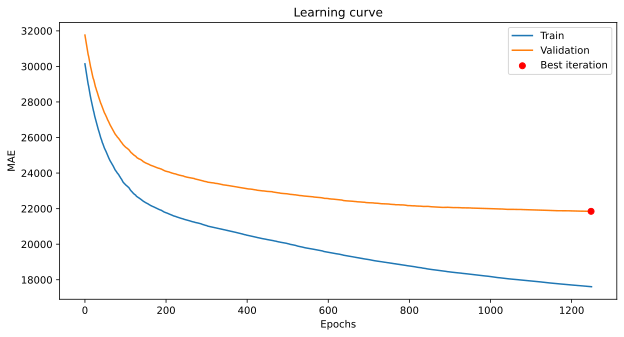

In [20]:
# Show iterations
epochs = np.arange(len(results['learn']['MAE']))

# Retrieve the best iteration from the model
best_iteration = tuned_model.get_best_iteration()

plt.figure(figsize=(10, 5))
plt.plot(epochs, results['learn']['MAE'], label='Train')
plt.plot(epochs, results['validation']['MAE'], label='Validation')

# Mark the best iteration on the plot
if best_iteration is not None:
    plt.scatter(best_iteration, results['validation']['MAE'][best_iteration], color='red', zorder=5, label='Best iteration')

plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Learning curve')
plt.legend()
plt.show()


In [21]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(5790, 16)


Column names
dataset 1:
['surface_volume_disorderliness_mean', 'surface_roughness_disorderliness_mean', 'ndbi_built_contrast_mean', 'tcap_wetness_mean', 'tcap_greenness_std', 'surface_structure_mean', 'nir_band_mean', 'swir2_band_std', 'colour_brightness_coherence_mean', 'ndwi_wetness_contrast_mean', 'ndwi_wetness_coherence_std', 'tcap_greenness_contrast_mean', 'tcap_wetness_coherence_mean', 'tcap_wetness_disorderliness_mean', 'x_coord', 'y_coord']


In [22]:
metrics = tuned_model.eval_metrics(
    data=pool1,
    metrics=['RMSE','MAE', 'R2'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=False
)

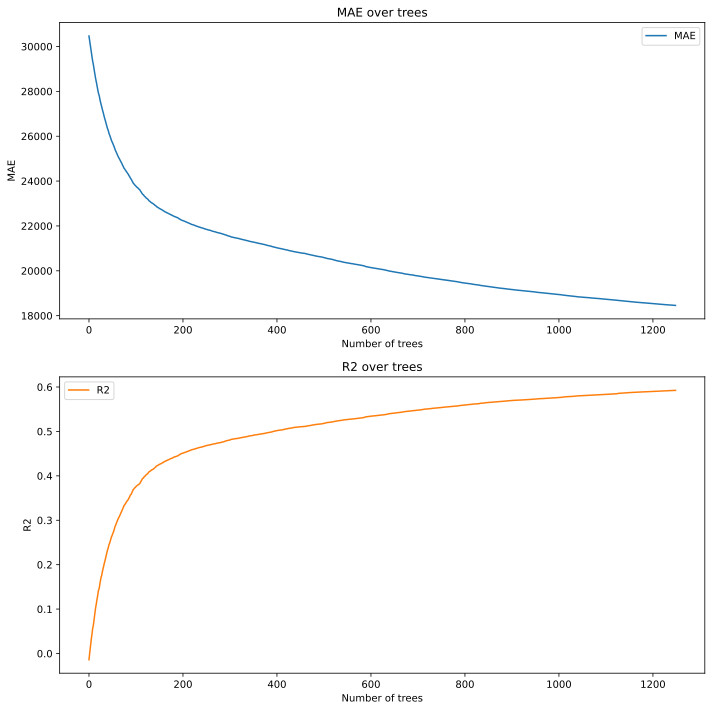

In [23]:
# Extracting metrics for plotting
mae_values = metrics['MAE']
r2_values = metrics['R2']
trees = list(range(len(mae_values)))  # Assuming eval_period=1 and starting from the first tree

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting RMSE
axs[0].plot(trees, mae_values, label='MAE', color='tab:blue')
axs[0].set_title('MAE over trees')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('MAE')
axs[0].legend()

# Plotting R2
axs[1].plot(trees, r2_values, label='R2', color='tab:orange')
axs[1].set_title('R2 over trees')
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('R2')
axs[1].legend()

plt.tight_layout()
plt.show()


In [24]:
tuned_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,y_coord,17.208046
1,x_coord,16.233934
2,tcap_wetness_disorderliness_mean,9.340974
3,ndbi_built_contrast_mean,7.572823
4,surface_roughness_disorderliness_mean,7.456970
5,nir_band_mean,6.514039
6,tcap_wetness_mean,4.825430
7,tcap_greenness_std,4.678516
8,surface_volume_disorderliness_mean,4.477185
9,swir2_band_std,4.409993


In [25]:

params = tuned_model.get_params()
params['loss_function'] = 'MAE'
params['custom_loss'] = 'R2'

cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 20111.64529
bestIteration = 1249

Training on fold [1/5]

bestTest = 20454.67747
bestIteration = 1249

Training on fold [2/5]

bestTest = 20421.07474
bestIteration = 1249

Training on fold [3/5]

bestTest = 21269.94749
bestIteration = 1249

Training on fold [4/5]

bestTest = 20436.25769
bestIteration = 1249



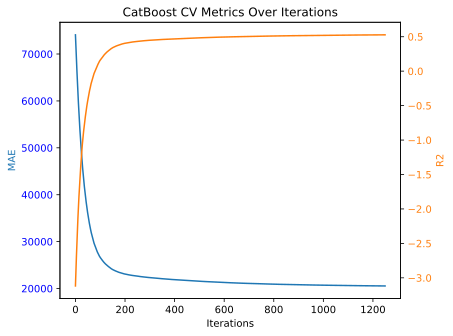

In [26]:
# Extracting the mean RMSE and R2 values from cv_data
mean_mae = cv_data['test-MAE-mean']
mean_r2 = cv_data['test-R2-mean']
iterations = range(len(mean_mae))

# Plotting the RMSE and R2 values
fig, ax1 = plt.subplots()

ax1.set_xlabel('Iterations')
ax1.set_ylabel('MAE', color='tab:blue')
ax1.plot(iterations, mean_mae, label='MAE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('R2', color='tab:orange')
ax2.plot(iterations, mean_r2, label='R2', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and legend
plt.title('CatBoost CV Metrics Over Iterations')
fig.tight_layout()  # To ensure the right y-label is not clipped
plt.show()

In [27]:
mae_values = cv_data['train-MAE-mean']
r2_values = cv_data['train-R2-mean']

# Create a DataFrame with both RMSE and R2 values
cv_results_df = pd.DataFrame({'MAE': mae_values, 'R2': r2_values})
cv_results_df

,MAE,R2
0,74094.258634,-3.104829
1,72713.071100,-2.986213
2,71418.420933,-2.879660
3,70110.843096,-2.773096
4,68858.954041,-2.673463
...,...,...
1245,17850.029378,0.610769
1246,17848.222461,0.610813
1247,17846.308708,0.610862
1248,17843.754093,0.610927


In [28]:
mae_values = cv_data['test-MAE-mean']
r2_values = cv_data['test-R2-mean']

# Create a DataFrame with both RMSE and R2 values
cv_results_df = pd.DataFrame({'MAE': mae_values, 'R2': r2_values})
cv_results_df

,MAE,R2
0,74094.593048,-3.117934
1,72713.321548,-2.998908
2,71418.915459,-2.892000
3,70111.456815,-2.785018
4,68860.040885,-2.685063
...,...,...
1245,20541.969144,0.527274
1246,20541.477589,0.527277
1247,20540.138651,0.527313
1248,20539.582252,0.527340


In [29]:
shap_values = tuned_model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

(5790, 17)


In [30]:
# Create a Pool object with the categorical feature specified
validation_pool = catboost.Pool(X_validation, label=y_validation)

# Calculate SHAP values
shap_values = tuned_model.get_feature_importance(validation_pool, type="ShapValues")

# Extract the expected value from the SHAP values output
expected_value = shap_values[0, -1]

# Exclude the expected value from the SHAP values (it's the last column)
shap_values = shap_values[:, :-1]

# Initialize JavaScript visualization in the notebook (for Jupyter Notebooks or JupyterLab)
shap.initjs()

# Create a force plot for a single prediction
# The index 3 is arbitrary, chosen to show the example. You can choose any index within the range of your dataset
shap.force_plot(expected_value, shap_values[3, :], X_validation.iloc[3, :])


In [31]:
# Create a figure and capture the plot
plt.figure()
plt.title('Impact on income in New York City')
shap.summary_plot(shap_values, X.values, plot_type="bar", feature_names=X.columns, show=False)

# Save the figure in SVG format
plt.savefig("shap_summary_plot_NYC.svg", format='svg', bbox_inches='tight')
plt.close()

In [32]:

plt.switch_backend('Agg')  # Switch to 'Agg' backend, which is better suited for file outputs
plt.title('Impact on income in New York City')

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_validation, show=False)  # Set show=False to prevent immediate display

# After generating the plot, get the current figure
fig = plt.gcf()

# Save the current figure in PDF format
fig.savefig("shap_dependency_plot_NYC.svg", format='svg', bbox_inches='tight')

# Optionally, close the figure to free up memory
plt.close(fig)


In [33]:
explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(X_validation)
shap_df = pd.DataFrame(shap_values, columns=X_validation.columns)
shap_df.to_csv('shap_values_nyc.csv', index=False)

In [35]:

# Define the model with IncToDec overfitting detection
model = CatBoostRegressor(
    random_seed=63,
    iterations=1250,
    task_type="CPU",
    learning_rate=0.02,
    l2_leaf_reg=55,
    depth=4,
    loss_function='MAE'
)

# Setup robust cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Prepare lists to store results
train_scores = []
test_scores = []
train_maes = []
test_maes = []
train_rmses = []
test_rmses = []

# Loop over each fold
for train_idx, test_idx in rkf.split(X):
    train_pool = Pool(X.iloc[train_idx], y.iloc[train_idx])
    test_pool = Pool(X.iloc[test_idx], y.iloc[test_idx])
    
    # Fit model with early stopping
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100, verbose=False)
    
    # Predict on train and test sets
    train_preds = model.predict(train_pool)
    test_preds = model.predict(test_pool)
    
    # Calculate R-squared
    train_scores.append(model.score(train_pool))
    test_scores.append(model.score(test_pool))
    
    # Calculate MAE
    train_maes.append(mean_absolute_error(y.iloc[train_idx], train_preds))
    test_maes.append(mean_absolute_error(y.iloc[test_idx], test_preds))
    
    # Calculate RMSE
    train_rmses.append(np.sqrt(mean_squared_error(y.iloc[train_idx], train_preds)))
    test_rmses.append(np.sqrt(mean_squared_error(y.iloc[test_idx], test_preds)))

# Calculate the average and standard deviation of R-squared across all train and test folds
mean_train_r2 = np.mean(train_scores)
std_train_r2 = np.std(train_scores)
mean_test_r2 = np.mean(test_scores)
std_test_r2 = np.std(test_scores)

# Calculate the average and standard deviation of MAE across all train and test folds
mean_train_mae = np.mean(train_maes)
std_train_mae = np.std(train_maes)
mean_test_mae = np.mean(test_maes)
std_test_mae = np.std(test_maes)

# Calculate the average and standard deviation of RMSE across all train and test folds
mean_train_rmse = np.mean(train_rmses)
std_train_rmse = np.std(train_rmses)
mean_test_rmse = np.mean(test_rmses)
std_test_rmse = np.std(test_rmses)

print("Average Train R-squared:", mean_train_r2)
print("Train R-squared Standard Deviation:", std_train_r2)
print("Average Test R-squared:", mean_test_r2)
print("Test R-squared Standard Deviation:", std_test_r2)
print("Average Train MAE:", mean_train_mae)
print("Train MAE Standard Deviation:", std_train_mae)
print("Average Test MAE:", mean_test_mae)
print("Test MAE Standard Deviation:", std_test_mae)
print("Average Train RMSE:", mean_train_rmse)
print("Train RMSE Standard Deviation:", std_train_rmse)
print("Average Test RMSE:", mean_test_rmse)
print("Test RMSE Standard Deviation:", std_test_rmse)


Average Train R-squared: 0.6130549336346311
Train R-squared Standard Deviation: 0.0059138897776007966
Average Test R-squared: 0.5276447149885805
Test R-squared Standard Deviation: 0.02338726763494005
Average Train MAE: 17813.033082746046
Train MAE Standard Deviation: 142.46886599495065
Average Test MAE: 20605.771284377384
Test MAE Standard Deviation: 674.9958439644766
Average Train RMSE: 26139.69303474597
Train RMSE Standard Deviation: 248.20229069211712
Average Test RMSE: 28846.094479939366
Test RMSE Standard Deviation: 1103.5873384672707
